<a href="https://colab.research.google.com/github/RMCV-Rajapaksha/TeamInception_Datathon/blob/malitha/task2_eda_and_data_preprocessing_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2 Notebook for "XGBoost"


## Imports and Setup

**Import the Libararies**


In [1]:
# !pip install tensorflow pandas numpy matplotlib scikit-learn

In [2]:
import pandas as pd
import os
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
warnings.filterwarnings('ignore')

### Connecting to Google Drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


### Reading data set files

In [4]:
# Developers please update the paths according to were in your google you place datasets
# i recommend making Rootcode-ML folder and in it Datasets folder and placing the csv files there then you wont have to change below code block
bookings_data = pd.read_csv('/content/drive/MyDrive/Rootcode-ML/Datasets/bookings_train.csv')
tasks_data = pd.read_csv('/content/drive/MyDrive/Rootcode-ML/Datasets/tasks.csv')
staffing_data = pd.read_csv('/content/drive/MyDrive/Rootcode-ML/Datasets/staffing_train.csv')

## EDA



### EDA of Staffing data

lets take a look at the columns and some of their values

In [5]:
staffing_data.head()

,date,section_id,employees_on_duty,total_task_time_minutes
0,2021-01-01,SEC-001,1,834.569483
1,2021-01-01,SEC-002,4,1525.368990
2,2021-01-01,SEC-003,2,662.095279
3,2021-01-01,SEC-004,4,1499.112620
4,2021-01-01,SEC-005,3,1238.533073


In [6]:
staffing_data.describe()

,employees_on_duty,total_task_time_minutes
count,5802.000000,5802.000000
mean,4.458807,1662.296769
std,2.794417,1147.134643
min,1.000000,91.109596
25%,3.000000,859.104314
50%,4.000000,1358.176924
75%,6.000000,2123.936358
max,26.000000,10658.173092


removing unnecessary columns. We wont need the total_task_time_minutes because this data wont be provided as input from the test datasets. We need the date and section_id  because they will be to calculate the actual target value (the thing to be predicted) for task 2.

In [7]:
staffing_data = staffing_data.drop(['total_task_time_minutes'],axis=1)

now lets look at the new table headers again.


In [8]:
staffing_data.head()

,date,section_id,employees_on_duty
0,2021-01-01,SEC-001,1
1,2021-01-01,SEC-002,4
2,2021-01-01,SEC-003,2
3,2021-01-01,SEC-004,4
4,2021-01-01,SEC-005,3


lets get a better idea of how null values have been distributed amoung the columns

In [9]:
staffing_data.isna().sum()

,0
date,0
section_id,0
employees_on_duty,0


### EDA of Bookings data

In [10]:
bookings_data.head()

,booking_id,citizen_id,booking_date,appointment_date,appointment_time,check_in_time,check_out_time,task_id,num_documents,queue_number,satisfaction_rating
0,f7b59ba3793fea61282cb02be2247cebd0a75306,4229044420,2021-01-01,2021-01-01,09:03,2021-01-01 09:11:00,2021-01-01 09:48:15.166353269,TASK-002,0,2,4
1,cfe30d53b4b645e4cb6b114f6c9d74a0f25e6a80,5389442635,2021-01-01,2021-01-01,09:12,2021-01-01 09:24:00,2021-01-01 10:24:12.189261137,TASK-001,1,1,4
2,0fb0a5d9b3944dd743a9e7828dc03fa74aa6ebf8,2123783919,2021-01-01,2021-01-01,09:36,2021-01-01 09:29:00,2021-01-01 10:26:48.802260864,TASK-002,1,6,5
3,d4bf826153212fa325ad98b215668ab942365607,6359918966,2021-01-01,2021-01-01,09:45,2021-01-01 10:07:00,2021-01-01 11:00:13.485642822,TASK-001,1,4,4
4,ebb4c9687acbaf65376d8e379bd1341d1c15127e,178732202,2021-01-01,2021-01-01,10:12,2021-01-01 10:26:00,2021-01-01 11:54:53.260180213,TASK-002,1,8,3


In [11]:
bookings_data.describe()

,citizen_id,num_documents,queue_number,satisfaction_rating
count,2.036930e+05,203693.000000,203693.000000,203693.000000
mean,4.996145e+09,2.436790,9.310511,4.187277
std,2.880985e+09,1.734511,8.245711,0.463539
min,4.318100e+04,0.000000,1.000000,3.000000
25%,2.504323e+09,1.000000,3.000000,4.000000
50%,4.995536e+09,2.000000,7.000000,4.000000
75%,7.491514e+09,3.000000,13.000000,4.000000
max,9.999975e+09,14.000000,133.000000,5.000000


In [12]:
bookings_data.isna().sum()

,0
booking_id,0
citizen_id,0
booking_date,0
appointment_date,0
appointment_time,0
check_in_time,6092
check_out_time,6092
task_id,0
num_documents,0
queue_number,0


### EDA of tasks data

In [13]:
tasks_data.head()

,task_id,task_name,section_id,section_name
0,TASK-001,Register new motor vehicles and issue registra...,SEC-001,Vehicle Registration
1,TASK-002,Process the transfer of vehicle ownership.,SEC-001,Vehicle Registration
2,TASK-003,Conduct theoretical and practical examinations...,SEC-002,Driver Licensing
3,TASK-004,Process the renewal and reissue of driving lic...,SEC-002,Driver Licensing
4,TASK-005,Issue international driving permits.,SEC-002,Driver Licensing


In [14]:
tasks_data.describe()

,task_id,task_name,section_id,section_name
count,19,19,19,19
unique,19,19,6,6
top,TASK-001,Register new motor vehicles and issue registra...,SEC-002,Driver Licensing
freq,1,1,4,4


In [15]:
tasks_data.isna().sum()

,0
task_id,0
task_name,0
section_id,0
section_name,0


# Merge Datasets

In [16]:
df_bookings_merged = pd.merge(bookings_data, tasks_data, on='task_id', how='left')
df_bookings_merged['appointment_date'] = pd.to_datetime(df_bookings_merged['appointment_date'])
df_workload = df_bookings_merged.groupby(
    [df_bookings_merged['appointment_date'].dt.date, 'section_id']
).agg(
    total_appointments=('booking_id', 'count'),
    total_documents=('num_documents', 'sum')
).reset_index()
df_workload = df_workload.rename(columns={'appointment_date': 'date'})

staffing_data['date'] = pd.to_datetime(staffing_data['date'])
df_workload['date'] = pd.to_datetime(df_workload['date'])
training_df = pd.merge(staffing_data, df_workload, on=['date', 'section_id'], how='left')

training_df['total_appointments'] = training_df['total_appointments'].fillna(0)
training_df['total_documents'] = training_df['total_documents'].fillna(0)

In [17]:
print(f"\nShape of the training data: {training_df.shape}")
print("\nMissing values check:")
training_df.isnull().sum()


Shape of the training data: (5802, 5)

Missing values check:


,0
date,0
section_id,0
employees_on_duty,0
total_appointments,0
total_documents,0


# Feature Engineering

In [18]:
def create_time_features(df):
    """Creates time-series features from a datetime column."""
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    df['is_weekend'] = (df['date'].dt.dayofweek >= 5).astype(int)
    return df

training_df = create_time_features(training_df)

# Handle Categorical Features (One-Hot Encoding)
if 'section_id' in training_df.columns:
    # MODIFIED LINE: Added dtype=int to ensure the new columns are 1s and 0s
    training_df = pd.get_dummies(training_df, columns=['section_id'], prefix='section', dtype=int)

print("✅ Data preparation and feature engineering complete.")
print("\nPreview of the final training data:")
training_df.head()

✅ Data preparation and feature engineering complete.

Preview of the final training data:


,date,employees_on_duty,total_appointments,total_documents,day_of_week,month,year,quarter,day_of_year,day_of_month,week_of_year,is_weekend,section_SEC-001,section_SEC-002,section_SEC-003,section_SEC-004,section_SEC-005,section_SEC-006
0,2021-01-01,1,13,18,4,1,2021,1,1,1,53,0,1,0,0,0,0,0
1,2021-01-01,4,35,106,4,1,2021,1,1,1,53,0,0,1,0,0,0,0
2,2021-01-01,2,21,51,4,1,2021,1,1,1,53,0,0,0,1,0,0,0
3,2021-01-01,4,32,64,4,1,2021,1,1,1,53,0,0,0,0,1,0,0
4,2021-01-01,3,23,56,4,1,2021,1,1,1,53,0,0,0,0,0,1,0


# Train the model

In [19]:
# Find the first and last date in your dataset
first_date = training_df['date'].min()
last_date = training_df['date'].max()

print(f"Your data's date range is from: {first_date.date()} to {last_date.date()}")

Your data's date range is from: 2021-01-01 to 2024-12-31


In [20]:
# --- Define Features (X) and Target (y) ---
y = training_df['employees_on_duty']
X = training_df.drop(columns=['employees_on_duty', 'date'])

# --- Time-Based Split ---
# Using the new split date based on your data's range.
split_date = '2024-03-01'

train_indices = training_df['date'] < split_date
val_indices = training_df['date'] >= split_date

X_train, X_val = X[train_indices], X[val_indices]
y_train, y_val = y[train_indices], y[val_indices]

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# --- Initialize and Train the XGBoost Model ---
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    objective='reg:squarederror',
    early_stopping_rounds=50,
    n_jobs=-1
)

print("\nTraining XGBoost model...")
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print("\n✅ Model training complete!")

Training data shape: (4602, 16)
Validation data shape: (1200, 16)

Training XGBoost model...

✅ Model training complete!


### Hyperparameter tunning (Grid Search)

In [24]:
from sklearn.model_selection import GridSearchCV

# --- 1. Define the grid of hyperparameters to test ---
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# --- 2. Initialize the Grid Search ---
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2
)

# --- 3. Run the search on your training data ---
print("⏳ Starting hyperparameter tuning... (This may take several minutes)")
grid_search.fit(X_train, y_train)

# --- 4. Get the best model and its parameters ---
print(f"\n✅ Tuning complete!")
print(f"Best parameters found: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

⏳ Starting hyperparameter tuning... (This may take several minutes)
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8; total time=   3.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8; total time=   0.5s
[CV] END learning_rat

# Evaluate the model performance

Model Performance on Validation Data:
Mean Absolute Error (MAE): 0.64
Root Mean Squared Error (RMSE): 0.81


Top 10 Most Important Features:
               feature  importance
0   total_appointments    0.403795
14     section_SEC-005    0.252151
15     section_SEC-006    0.143150
12     section_SEC-003    0.074621
11     section_SEC-002    0.032095
10     section_SEC-001    0.027474
1      total_documents    0.018555
13     section_SEC-004    0.015312
4                 year    0.011097
2          day_of_week    0.005092


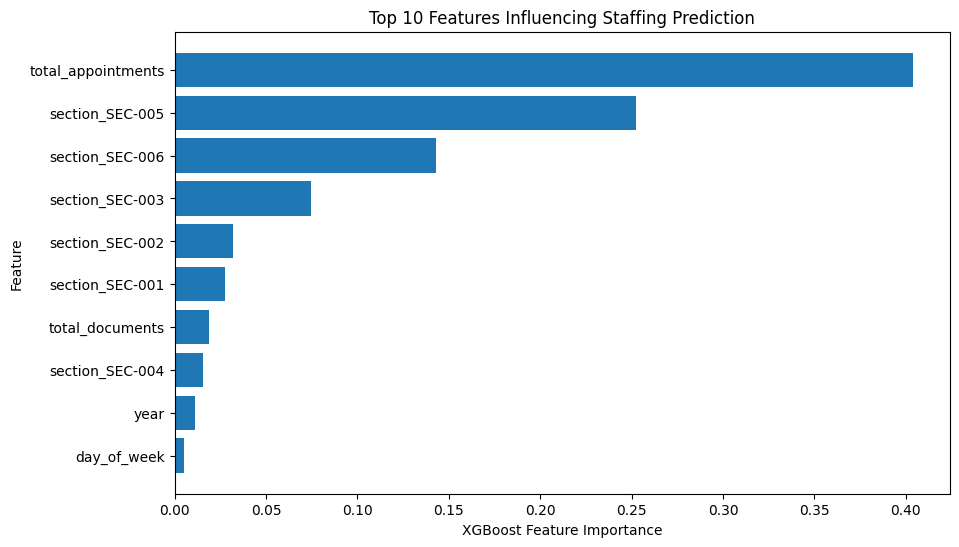

In [25]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error


# Make predictions on the validation data
y_pred = best_model.predict(X_val)

# Calculate performance metrics
mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)

print(f"Model Performance on Validation Data:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# --- Feature Importance ---
# This tells us which features the model relied on the most
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n\nTop 10 Most Important Features:")
print(feature_importances.head(10))


# --- Plot Feature Importance ---
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'][:10], feature_importances['importance'][:10])
plt.xlabel('XGBoost Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features Influencing Staffing Prediction')
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.show()

In [26]:
from sklearn.metrics import r2_score

# If you haven't already, make predictions on the validation data
y_pred = best_model.predict(X_val)

# Calculate the R-squared value
r2 = r2_score(y_val, y_pred)

print(f"Model Performance on Validation Data:")
print(f"R-squared (R²): {r2:.2f}")

Model Performance on Validation Data:
R-squared (R²): 0.90


Preiction Function

In [23]:
# Store the column order from the training data
# This is crucial to prevent errors in the prediction function
final_model_features = X_train.columns

def predict_staff_count(date_str, section_id_str, model, bookings_df, tasks_df, feature_columns):
    """
    Predicts the required staff count for a single future date and section.
    """
    # 1. Create a DataFrame from the inputs
    input_data = pd.DataFrame([{'date': date_str, 'section_id': section_id_str}])

    # 2. Engineer Workload Features
    # Count appointments already booked for that date and section
    bookings_with_sections = pd.merge(bookings_df, tasks_df, on='task_id', how='left')

    # Ensure date types are consistent for filtering
    target_date = pd.to_datetime(date_str).date()
    bookings_with_sections['appointment_date'] = pd.to_datetime(bookings_with_sections['appointment_date']).dt.date

    appointments_on_day = bookings_with_sections[
        (bookings_with_sections['appointment_date'] == target_date) &
        (bookings_with_sections['section_id'] == section_id_str)
    ]

    input_data['total_appointments'] = len(appointments_on_day)
    input_data['total_documents'] = appointments_on_day['num_documents'].sum()

    # 3. Engineer Time-Based Features
    input_data = create_time_features(input_data)

    # 4. One-Hot Encode the section_id
    input_data = pd.get_dummies(input_data, columns=['section_id'], prefix='section', dtype=int)

    # 5. Align columns with the model's training data
    # Add any missing one-hot encoded columns and fill with 0
    for col in feature_columns:
        if col not in input_data.columns:
            input_data[col] = 0

    # Ensure the order is exactly the same as the training data
    input_data = input_data[feature_columns]

    # 6. Make Prediction
    prediction = model.predict(input_data)

    # Return the result as a rounded integer
    return round(prediction[0])

# --- EXAMPLE USAGE ---
# Let's predict for a future date
future_date = '2025-09-29'
section = 'SEC-001' # Use one of your actual section IDs

predicted_employees = predict_staff_count(future_date, section, model, bookings_data, tasks_data, final_model_features)

print(f"\n\n--- Prediction ---")
print(f"Predicted number of employees needed in section '{section}' on {future_date}: {predicted_employees}")



--- Prediction ---
Predicted number of employees needed in section 'SEC-001' on 2025-09-29: 2
